In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.formula.api as smf

min   2024-01-03
max   2024-08-30
Name: date, dtype: datetime64[us]


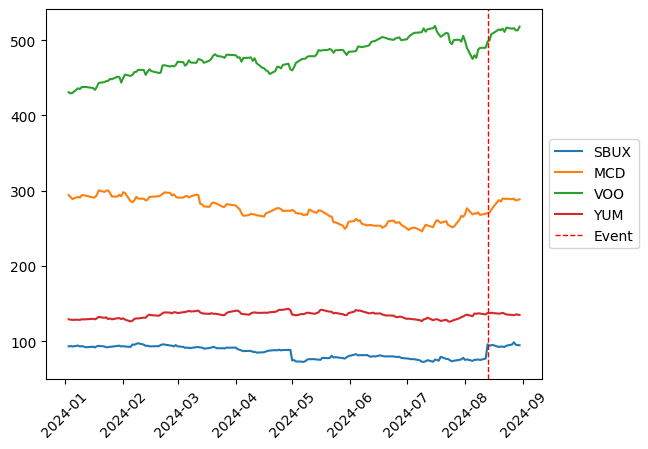

In [15]:
event_date = pd.to_datetime('2024-08-13')
prices = pd.read_csv('../Data Sources/prices.csv')
prices = prices[prices['returns'].isnull()==0].copy()
prices['date'] = pd.to_datetime(prices['date'])
print(prices['date'].agg(['min','max']))
prices.head()

prices[(prices['date']<event_date)&(prices['ticker']=='SBUX')]


for ticker in ['SBUX', 'MCD', 'VOO', 'YUM']:
    data = prices[prices['ticker'] == ticker]
    plt.plot(data['date'], data['close'], label=ticker)

plt.axvline(event_date, color='red', linestyle='--', linewidth=1, label='Event')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.show()

In [16]:
subset_prices = prices.pivot(index='date', columns='ticker', values='returns')
subset_prices.reset_index(inplace=True)
subset_prices.columns.name = None
subset_prices['date'] = pd.to_datetime(subset_prices['date'])

subset_prices.head()

,date,MCD,SBUX,VOO,YUM
0,2024-01-03,-0.008921,-0.004697,-0.007419,0.000543
1,2024-01-04,-0.009002,0.003432,-0.003157,-0.003176
2,2024-01-05,-0.009426,-0.005986,0.001281,-0.002720
3,2024-01-08,0.010070,0.012905,0.014303,0.002338
4,2024-01-09,-0.003529,-0.011679,-0.002430,-0.003265


In [17]:
preperiod_days = 120
postperiod_days = 1

event_date = pd.to_datetime(event_date)

model_start_date = event_date - pd.Timedelta(days=120)
model_end_date = event_date + pd.Timedelta(days=1)

# TO-DO: SUBSET THE DATA FOR RELEVANT DATES AND THEN RUN THE EVENT STUDY MODEL 
subset = subset_prices.loc[(subset_prices['date']>=model_start_date) & (subset_prices['date']<=model_end_date)].copy()
subset['event'] = np.where(subset['date']==event_date,1,0)
# subset['SBUX_lag1'] = subset['SBUX'].shift(1)

formula = 'SBUX~MCD+VOO+YUM+event'
model = smf.ols(formula=formula, data=subset).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   SBUX   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     37.21
Date:                Wed, 18 Feb 2026   Prob (F-statistic):           1.49e-17
Time:                        18:10:04   Log-Likelihood:                 206.44
No. Observations:                  85   AIC:                            -402.9
Df Residuals:                      80   BIC:                            -390.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0009      0.002     -0.378      0.7

In [18]:
total_shares = 1132800000

pre_event_data = subset[subset['date']<event_date]
prices['date'] = pd.to_datetime(prices['date'])
before_event_date = pre_event_data['date'].max()
last_price = prices.loc[(prices['date']==before_event_date)&(prices['ticker']=='SBUX')]['close'].values[0]

lastmarketvalue = last_price * total_shares
gain = lastmarketvalue * model.params['event']

print(last_price)
print("Last Market Value: ${:,}".format(round(lastmarketvalue)))
print("Estimated Gain: ${:,}".format(round(gain)))

77.02999877929688
Last Market Value: $87,259,582,617
Estimated Gain: $19,997,083,906


In [19]:
placebo_start_date = event_date - pd.Timedelta(days=120)
pre_event_dates = subset_prices[(subset_prices['date'] >= placebo_start_date) & (subset_prices['date'] < event_date)]['date'].unique()

#mytitle = "Event Study Placebo Distribution"

def get_event_study_placebos(df, pre_event_dates, cutoff_days, formula):
    pvalues = list()
    betas = list()
    
    for placebo_date in pre_event_dates:
        cutoff = pd.to_datetime(placebo_date) - pd.Timedelta(days=cutoff_days)
        placebo_df = subset_prices[(subset_prices['date'] >= cutoff) & (subset_prices['date'] <= placebo_date)].copy()
        placebo_df['event'] = np.where(placebo_df['date']==placebo_date,1,0)
        placebo_model=smf.ols(formula=formula, data=placebo_df).fit()
        pvalues.append(placebo_model.pvalues['event'])
        betas.append(placebo_model.params['event'])

    placebo_estimates = pd.DataFrame({'betas':betas, 'pvalues':pvalues})
    rmse = np.sqrt((placebo_estimates['betas']**2).mean())

    return(placebo_estimates,rmse)

placebo_estimates, rmse = get_event_study_placebos(subset_prices, pre_event_dates, preperiod_days, formula)


In [20]:
print(f"Mean Placebo Effect: {placebo_estimates.betas.mean():.3f}")
print(f"RMSE: {rmse:.3f}")

Mean Placebo Effect: 0.001
RMSE: 0.026


In [21]:
def plot_histogram(df, model, param, mytitle):
    quantile_2_5 = df['betas'].quantile(0.025)
    quantile_97_5 = df['betas'].quantile(0.975)
    model_est = model.params[param]

    plt.hist(df['betas'], bins=10, alpha=0.7)
    plt.axvline(quantile_2_5, color='black', linestyle='--', linewidth=1, label='2.5th pctl')
    plt.axvline(quantile_97_5, color='black', linestyle='--', linewidth=1, label='97.5th pctl')
    plt.axvline(model_est, color='red', linestyle='--', linewidth=1, label='Event Impact')
    plt.legend(loc='upper left')
    plt.title(mytitle)
    plt.show()

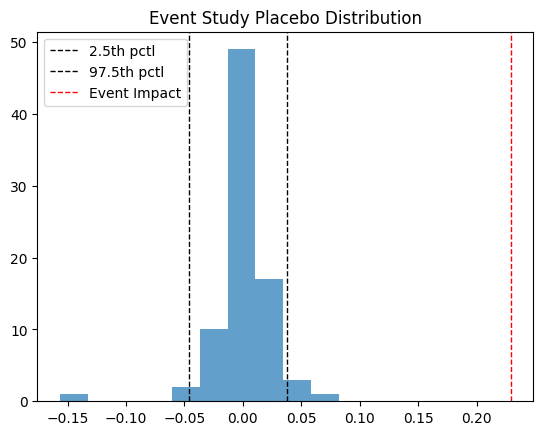

In [22]:
plot_histogram(placebo_estimates, model,"event", "Event Study Placebo Distribution")